# Begin

## Memorization

In [1]:
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torchvision
import torchvision.transforms as transforms

from utils_temporary_change_name import dataset

d1 = torchvision.datasets.CIFAR100(root='/home/huzhanhao/data/data/CIFAR100', train=True, transform=transforms.ToTensor(), download=True)
d2 = torchvision.datasets.CIFAR100(root='/home/huzhanhao/data/data/CIFAR100', train=False, transform=transforms.ToTensor(), download=True)
datas = np.concatenate([d1.data, d2.data])
datas = datas / 255
labels = np.concatenate([d1.targets, d2.targets])

Files already downloaded and verified
Files already downloaded and verified


In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
device = torch.device('cuda:0')
home = os.environ['HOME']
root = os.path.join(os.environ['HOME'], 'ssd')
cache_dir = os.path.join(root, 'cache/privacy')

In [3]:
os.path.join(cache_dir, 'memorization/cifar100_infl_matrix.npz')

'/home/huzhanhao/ssd/cache/privacy/memorization/cifar100_infl_matrix.npz'

In [4]:
infl_matrix = np.load(os.path.join(cache_dir, 'memorization/cifar100_infl_matrix.npz'))
tr_mem = infl_matrix['tr_mem']

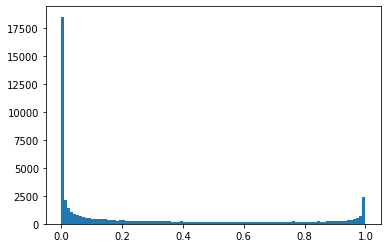

In [5]:
plt.hist(tr_mem, 100);

## diff feature

In [18]:
from others_project.lixiao.privacy_and_aug.models import ResNet18
from privacy.utils import computeMetrics

root = "/home/lixiao/ssd/privacy_and_aug"
sample_num = 60000

with open("others_project/lixiao/privacy_and_aug/sampleinfo/samplelist.txt", "r") as f:
    samplelist = eval(f.read())
    
def normal(mu, sigma2, x):
    r = - np.log(sigma2) / 2 - (x - mu) ** 2 / (2 * sigma2)
    return r
def ROC_curve(sample_inds, pred, save = False, show = True, name = "test"):
    y = torch.zeros(sample_num)
    y[sample_inds] = 1
    pos = np.sum(y == 1)
    neg = np.sum(y == 0)
    pred_sort = np.sort(pred)[::-1]
    index = np.argsort(pred)[::-1]
    y_sort = y[index]
    tpr = []
    fpr = []
    thr = []
    for i,item in enumerate(pred_sort):
        tpr.append(np.sum((y_sort[:i] == 1)) / pos)
        fpr.append(np.sum((y_sort[:i] == 0)) / neg)
        thr.append(item)
    for i in range(len(fpr)-1, -1, -1):
        if fpr[i] <= 1e-3:
#             print("TPR @ 0.1% FPR: ", (str(tpr[i] * 100)))
            tpr_0_1 = tpr[i] * 100
            break
    for i in range(len(fpr)-1, -1, -1):
        if fpr[i] <= 1e-4:
#             print("TPR @ 0.01% FPR: ", (str(tpr[i] * 100)))
            tpr_00_1 = tpr[i] * 100
            break
    for i in range(len(fpr)-1, -1, -1):
        if fpr[i] <= 1e-5:
#             print("TPR @ 0.001% FPR: ", (str(tpr[i] * 100)))
            tpr_000_1 = tpr[i] * 100
            break
    logfpr = np.log10(np.array(fpr) + 1e-5)
    logtpr = np.log10(np.array(tpr) + 1e-5) + 5
    # logfpr = np.array(fpr)
    # logtpr = np.array(tpr)
    eps = logfpr[1:] - logfpr[:-1]
    auroc = np.sum(eps * np.array(logtpr)[1:]) / (5 * 5)
#     print("AUROC: ", auroc)
    
    #画图
    if show:
        plt.yscale('log')
        plt.xscale('log')
        plt.plot(fpr, tpr, 'k')
        plt.title('Receiver Operating Characteristic: %s' % (aug_type))
        plt.plot([(0,0),(1,1)],'r--')
        plt.xlim([1e-5,1])
        plt.ylim([1e-5,1])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        if save:
            plt.savefig(name + ".pdf", dpi=300)
        else:
            plt.show()
    return tpr_0_1, tpr_00_1, tpr_000_1, auroc

def compute_feature(aug_type, trial, dataset, test_ids=0):
    dirs = os.path.join(root, "phy_multi", dataset, aug_type)
    allmodellist = list(range(0, 128))
    allmodellist.remove(trial)

    IN = []
    OUT = []
    for i in range(sample_num):
        IN.append([])
        OUT.append([])
    alls = [i for i in range(sample_num)]
    for index in allmodellist:
        slist = samplelist[index]
        for it in slist:
            IN[it].append(index)
        outslist = set(alls) - set(slist)
        for it in outslist:
            OUT[it].append(index)

    npdict = dict()
    for index in allmodellist:
        npdict[index] = np.load("%s/phy_multi_%s.npy" % (dirs, str(index)))[:, test_ids]

    print('computing mean & var for in & out')
    in_dict = dict()
    out_dict = dict()
    confs_dict = dict()
    for i in range(sample_num):
        confsin, confsout = [], []
        for it in IN[i]:
            x = npdict[it][i]
            confsin.append(x)
        for it in OUT[i]:
            x = npdict[it][i]
            confsout.append(x)
        confsin = np.array(confsin)
        confsout = np.array(confsout)
        in_u, in_sigma = np.mean(confsin), np.var(confsin)
        out_u, out_sigma = np.mean(confsout), np.var(confsout)
        in_dict[i] = (in_u, in_sigma)
        out_dict[i] = (out_u, out_sigma)
        confs_dict[i] = (confsin, confsout)

    print('test one model')
    base = np.load("%s/phy_multi_%s.npy" % (dirs, str(trial)))[:, test_ids]
    base_in = []
    base_out = []
    for i in range(sample_num):
        a = normal(in_dict[i][0], in_dict[i][1], base[i])
        b = normal(out_dict[i][0], out_dict[i][1], base[i])
        base_in.append(a)
        base_out.append(b)
    base_in = np.array(base_in)
    base_out = np.array(base_out)
    baseeval = base_in - base_out
    return base, baseeval, confs_dict

print('done')

done


computing mean & var for in & out
test one model
MIA AUROC is 0.9072, success rate is 0.8031 with threshold -0.0988


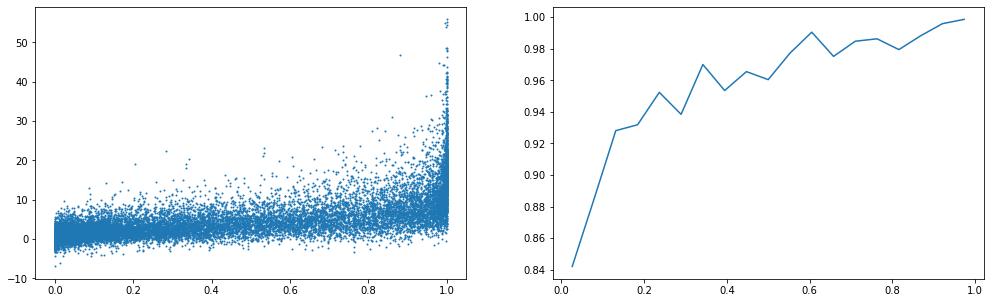

In [15]:
aug_type = 'base'
dataset = 'cifar100'
trial = 0

base, baseeval, confs_dict = compute_feature(aug_type, trial, dataset)

# scatter all training samples
# scores = base
# scores = 1 / (1 + np.exp(-base))
scores = baseeval
# scores = 1 / (1 + np.exp(-baseeval))

FPR = np.linspace(0, 1, 101)
indicator = np.zeros(sample_num, dtype=np.bool_)
indicator[samplelist[trial]] = True
scores_io = [scores[indicator], scores[np.logical_not(indicator)]]
metrics = computeMetrics(scores_io, FPR)
print('MIA AUROC is %.4f, success rate is %.4f with threshold %.4f' % (metrics['AUROC'], metrics['acc_opt'], metrics['thr_opt'], ))

sids = np.array(samplelist[trial])
sids = sids[sids < 50000]

mem = tr_mem[sids]
scores = scores[sids]

inds = np.argsort(mem)
mem = mem[inds]
scores = scores[inds]

plt.figure(figsize=(17, 5))
plt.subplot(1,2,1)
plt.scatter(mem, scores, s=1)

# mean in bins
bin_num = 20
bins = np.linspace(0, 1, bin_num)[np.newaxis, :]
mem_pb = mem[:, np.newaxis]
inds = mem_pb <= bins
nums = inds.sum(0)
sums = ((scores[:, np.newaxis] > metrics['thr_opt']) * inds).sum(0)
# sums = (scores[:, np.newaxis] * inds).sum(0)

nums = nums[1:] - nums[:-1]
sums = sums[1:] - sums[:-1]
mean = sums / nums

plt.subplot(1,2,2)
plt.plot((bins[0, :-1] + bins[0, 1:])/2, mean)

In [37]:
aug_types_selected = ['base', 'smooth', 'jitter', 'disturblabel', 'pgdat', 'trades', 'AWP', 'TradesAWP'] + ['pgdat_1', 'pgdat_2', 'pgdat_4', 'pgdat']
dataset = 'cifar100'
trial = 0

bases = []
baseevals = []
confs_dicts = []

for aug_type in aug_types_selected:
    base, baseeval, confs_dict = compute_feature(aug_type, trial, dataset)
    bases.append(base)
    baseevals.append(baseeval)
    confs_dicts.append(confs_dict)

indicator = np.zeros(sample_num, dtype=np.bool_)
indicator[samplelist[trial]] = True


unscale = lambda x: 1 / (1 + np.exp(-x))

confs = [unscale(b) for b in bases]
confs_io = [[c[indicator], c[np.logical_not(indicator)]] for c in confs]

# memfeatures = baseevals
memfeatures = [unscale(b) for b in baseevals]
memfeatures_io = [[c[indicator], c[np.logical_not(indicator)]] for c in memfeatures]


memfeatures2 = baseevals
memfeatures_io2 = [[c[indicator], c[np.logical_not(indicator)]] for c in memfeatures2]

memorizations = [[unscale(confs_dicts[ids][i][0]).mean() - unscale(confs_dicts[ids][i][1]).mean() for i in range(sample_num)] for ids in range(len(confs_dicts))] 

print('done')

computing mean & var for in & out
test one model
computing mean & var for in & out
test one model
computing mean & var for in & out
test one model
computing mean & var for in & out
test one model
computing mean & var for in & out
test one model
computing mean & var for in & out
test one model
computing mean & var for in & out
test one model
computing mean & var for in & out
test one model
computing mean & var for in & out
test one model
computing mean & var for in & out
test one model
computing mean & var for in & out
test one model
computing mean & var for in & out
test one model
done


In [38]:
from statistics import NormalDist

diffs_tt = []
for i, c in enumerate(confs_dicts):
    diffs = []
    for sids in tqdm(range(sample_num)):
        diff = NormalDist(mu=c[sids][0].mean(), sigma=c[sids][0].std()).overlap(NormalDist(mu=c[sids][1].mean(), sigma=c[sids][0].std()))
        diffs.append(diff)
    diffs_tt.append(diffs)
diffs_tt = np.array(diffs_tt)

100%|██████████████████████████████████████████████████████████████████████████████████████████| 60000/60000 [00:05<00:00, 11486.14it/s]


In [39]:
diffs_means_tt = []
for i, c in enumerate(confs_dicts):
    diffs = []
    for sids in tqdm(range(sample_num)):
#         diff = NormalDist(mu=c[sids][0].mean(), sigma=c[sids][0].std()).overlap(NormalDist(mu=c[sids][1].mean(), sigma=c[sids][0].std()))
        diff = c[sids][0].mean() - c[sids][1].mean()
        diffs.append(diff)
    diffs_means_tt.append(diffs)
diffs_means_tt = np.array(diffs_means_tt)

100%|██████████████████████████████████████████████████████████████████████████████████████████| 60000/60000 [00:01<00:00, 46802.21it/s]


In [ ]:
x = memfeatures_io[xi][0]
y = memfeatures_io[yi][0]
plt.scatter(x, y, s=1)

In [655]:
import sklearn
from sklearn.metrics.cluster import normalized_mutual_info_score
normalized_mutual_info_score(x, y)

/home/huzhanhao/ssd/anaconda3/envs/torch10/lib/python3.8/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)


0.9988630432948765

In [657]:
sklearn.metrics.mutual_info_score(x, y)

/home/huzhanhao/ssd/anaconda3/envs/torch10/lib/python3.8/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)


10.282775720772719

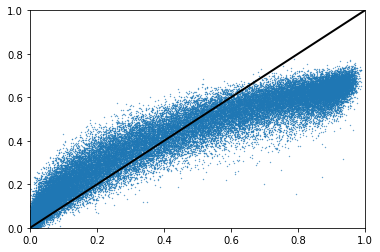

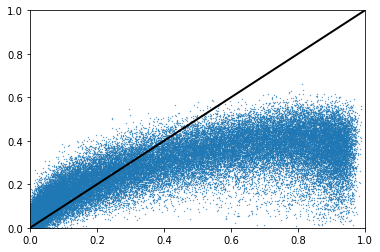

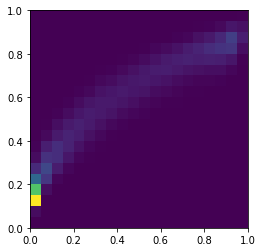

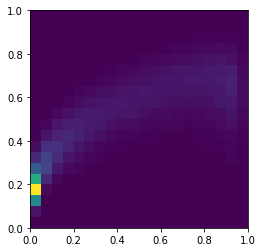

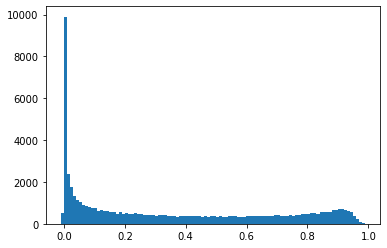

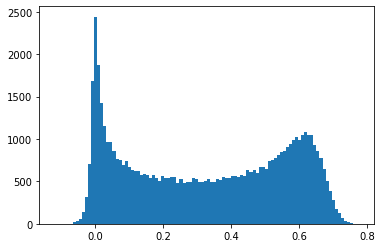

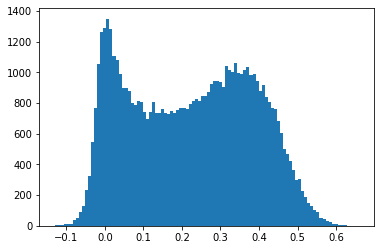

In [24]:
# aug_types_selected = ['base', 'smooth', 'jitter', 'disturblabel', 'pgdat', 'trades', 'AWP', 'TradesAWP']

memorizations0 = memorizations[0]
memorizations1 = memorizations[1]
memorizations2 = memorizations[3]

x = np.linspace(0, 1, 100)

scatter_num = 60000
plt.figure()
plt.scatter(memorizations0[:scatter_num], memorizations1[:scatter_num], s=0.1)
plt.plot(x, x, c='k', linewidth=2)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.figure()
plt.scatter(memorizations0[:scatter_num], memorizations2[:scatter_num], s=0.1)
plt.plot(x, x, c='k', linewidth=2)
plt.xlim([0, 1])
plt.ylim([0, 1])

heatmap, xedges, yedges = np.histogram2d(memorizations0, memorizations1, bins=20)
plt.figure()
plt.imshow(heatmap.T, extent=[0, 1, 0, 1], origin='lower')
plt.show()

heatmap, xedges, yedges = np.histogram2d(memorizations0, memorizations2, bins=20)
plt.figure()
plt.imshow(heatmap.T, extent=[0, 1, 0, 1], origin='lower')
plt.show()


plt.figure()
plt.hist(memorizations0, 100);
plt.figure()
plt.hist(memorizations1, 100);
plt.figure()
plt.hist(memorizations2, 100);

In [724]:
# y = np.zeros(sample_num)
# y[samplelist[trial]] = 1
# tpr_0_1, tpr_00_1, tpr_000_1, auroc, _ = ROC_curve(y, baseevals[0], show = False)


In [850]:
ms = np.array(memorizations)
x = ms[0] > 0.9
# x = np.logical_and(x, ms[0] < 0.9)
x = np.logical_and(x, ms[5] < 0.3)
x.nonzero()[0][:5]

array([ 48,  86, 138, 163, 306])

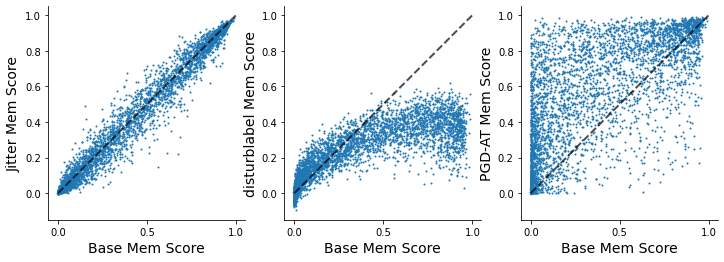

In [268]:
from others_project.lixiao.privacy_and_aug.eval_privacy import ROC_curve
from utils_temporary_change_name import dataset
from statistics import NormalDist
import matplotlib as mpl
# import matplotlib.pyplot as plt

mpl.rcParams["font.size"] = 14

# sid_insamples = [19, 0, 97]
# sids = [samplelist[trial][s] for s in sid_insamples] # [31, 164, 169]
sids = [169, 29, 163]
scatter_num = 4000

markers = ['^'] * 10
# colors = ['tomato', 'y', 'yellowgreen']
colors = np.array([(1., 0., 0.), (0.7, 0.7, 0.0), (0.0, 1.0, 0.0)])

# aug_types_selected = ['base', 'smooth', 'jitter', 'disturblabel', 'pgdat', 'trades', 'AWP', 'TradesAWP']
# names = aug_types_selected
names = ['Base', 'Smooth', 'Jitter', 'disturblabel', 'PGD-AT', 'TRADES', 'AWP', 'TRADES-AWP'] + ['$\epsilon=1$', '$\epsilon=2$', '$\epsilon=4$', '$\epsilon=8$']

# plt.figure(figsize=(3, 9))
# plt.figure(figsize=(9, 4))
# plt.figure(figsize=(9, 9))
plt.figure(figsize=(12, 9))

iter_xy = [[0, 2], [0, 3], [0, 4]]
# iter_xy = [[0, 4], [0, 5], [0, 6], [0, 7]]
# iter_xy = [[4, 4], [4, 5], [4, 6], [4, 7]]
f_num = len(iter_xy)
for si, [xi, yi] in enumerate(iter_xy):
# for si, [xi, yi] in enumerate([[0, 4], [0, 5]]):
    plt.subplot(1, f_num, si+1)
#     plt.subplot(2, 2, si+1)
#     score_select = 1-diffs_tt
#     score_select = diffs_means_tt
    score_select = memorizations
    plt.scatter(score_select[xi][:scatter_num], score_select[yi][:scatter_num], s=1.0)
    x = np.linspace(0, 1, 100)
    plt.plot(x, x, '--', c='k', linewidth=2, alpha=0.7)
##     put examples
#     hs = []
#     for i, sid in enumerate(sids):
#         h = plt.scatter(memorizations[xi][sid], memorizations[yi][sid], s=200, marker=markers[i], c=colors[i, np.newaxis])
#         hs.append(h)
##     plt.scatter(memfeatures_io2[xi][0], memfeatures_io2[yi][0], s=0.1)
##     plt.scatter(memfeatures_io2[xi][0][sids_insample], memfeatures_io2[yi][0][sids_insample], s=300, marker='^', c='r')

    plt.ylim([-0.15, 1.05])
#     plt.xlim([-0.05, 1.05])
    
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
#     if si == f_num - 1:
#         plt.ylabel(names[yi] + ' Mem Score')

#     plt.xlabel(names[xi] + ' Memorization Score')
    plt.xlabel(names[xi] + ' Mem Score')
    plt.ylabel(names[yi] + ' Mem Score')
##     put legend
#     if si == 0:
#         plt.legend(hs, [dataset.cifar100_labels[labels[sid]].capitalize() for sid in sids])
    
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_aspect('equal')
    
    # plt.figure()
    # plt.scatter(x[1], y[1], s=1)
plt.savefig('scatters.pdf', dpi=300, bbox_inches='tight')

# for si, [xi, yi] in enumerate([[0, 4], [0, 2]]):
# # for si, [xi, yi] in enumerate([[0, 4], [0, 5]]):
#     plt.subplot(2, 1, si+1)
#     plt.scatter(memfeatures_io[xi][0][:scatter_num], memfeatures_io[yi][0][:scatter_num], s=1)
#     hs = []
#     for i, sid_insample in enumerate(sid_insamples):
#         h = plt.scatter(memfeatures_io[xi][0][sid_insample], memfeatures_io[yi][0][sid_insample], s=200, marker=markers[i], c=colors[i])
#         hs.append(h)
# #     plt.scatter(memfeatures_io2[xi][0], memfeatures_io2[yi][0], s=0.1)
# #     plt.scatter(memfeatures_io2[xi][0][sids_insample], memfeatures_io2[yi][0][sids_insample], s=300, marker='^', c='r')

#     plt.xlabel(aug_types_selected[xi].capitalize() + r' $\mathrm{log}(\Lambda)/(\mathrm{log}(\Lambda)+1)$')
#     plt.ylabel(aug_types_selected[yi].capitalize() + r' $\mathrm{log}(\Lambda)/(\mathrm{log}(\Lambda)+1)$')
#     if si == 0:
#         plt.legend(hs, [dataset.cifar100_labels[labels[sid]].capitalize() for sid in sids])
    
#     ax = plt.gca()
#     ax.spines['top'].set_visible(False)
#     ax.spines['right'].set_visible(False)
    
#     # plt.figure()
#     # plt.scatter(x[1], y[1], s=1)
# plt.savefig('scatters.pdf', dpi=300, bbox_inches='tight')


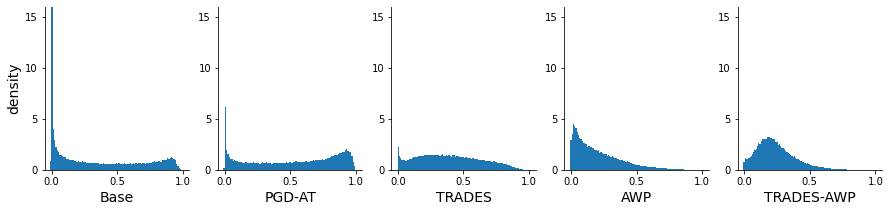

In [190]:
ids = [0, 4, 5, 6, 7]
plt.figure(figsize=(15, 3))
scatter_num = 60000
for si, xi in enumerate(ids):
    plt.subplot(1, len(ids), si+1)
    plt.hist(memorizations[xi][:scatter_num], 100, density=True)
    plt.ylim([0.0, 16.0])
    plt.xlim([-0.05, 1.05])
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.xlabel(names[xi])
    if si == 0:
        plt.ylabel('density')
        
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
plt.savefig('histogram.pdf', dpi=300, bbox_inches='tight')

In [193]:
ms = np.array(memorizations)
x = ms[0] > 0.4
x = np.logical_and(x, ms[0] < 0.5)
# x = np.logical_and(x, ms[5] < 0.3)
x.nonzero()[0][:5]

array([ 2,  8, 11, 23, 47])

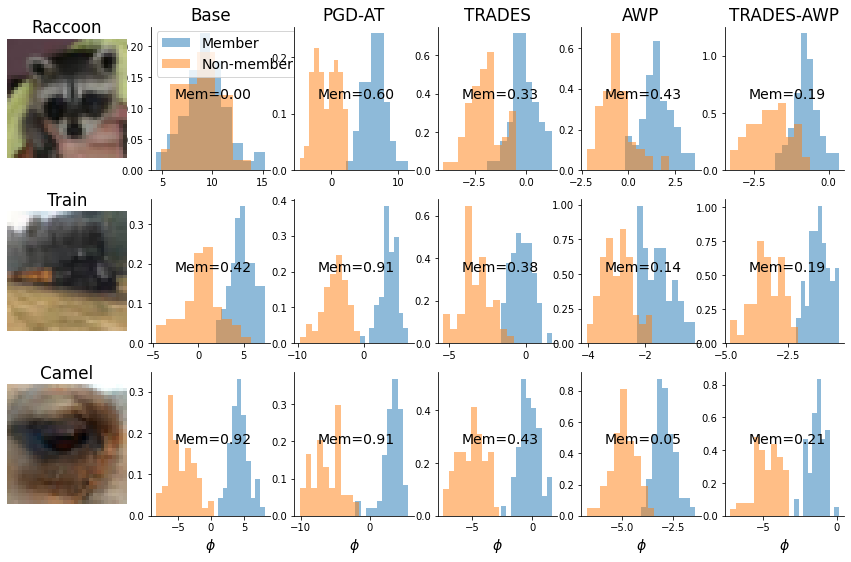

In [220]:
ms = np.array(memorizations)
# iter_xy = [[0, 8], [0, 9], [0, 10], [0, 11]]
iter_xy = [[0, 4], [0, 5], [0, 6], [0, 7]]
sids = [169, 47, 91]
# sids = [169, 11, 91]

plt.figure(figsize=(15, 9))
for tti, sid in enumerate(sids):
    for si, i in enumerate([0] + [a[1] for a in iter_xy]):
#     for si, i in enumerate([0, 4, 2]):
        c = confs_dicts[i]
    #     plt.figure()
#         plt.subplot(len(sids), f_num + 2, tti * (f_num + 2) + si + 1)
        plt.subplot(len(sids), f_num + 2, tti * (f_num + 2) + si + 1 + 1)
    #     diff = c[sid][0].mean() - c[sid][1].mean()
#         diff = NormalDist(mu=c[sid][0].mean(), sigma=c[sid][0].std()).overlap(NormalDist(mu=c[sid][1].mean(), sigma=c[sid][0].std()))
        if tti == 0:
            plt.title(names[i])
    #     plt.title('%s %.5f' % (aug_types_selected[i].capitalize(), diff))
        plt.hist(c[sid][0], 10, density=True, alpha=0.5)
        plt.hist(c[sid][1], 10, density=True, alpha=0.5)
        plt.xticks(fontsize=10)
        plt.yticks(fontsize=10)
        if tti == len(sids) - 1:
            plt.xlabel(r'$\phi$')
        if si == 0:
            if tti == 0:
                plt.legend(['Member', 'Non-member'], loc=[0.05, 0.65])
#                 plt.legend(['Member', 'Non-member'], loc=[0.05, 0.65])
            plt.ylabel('Density')
        ax = plt.gca()
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        l = 0.8
        x = l * xlim[0] + (1-l) * xlim[1]
        l = 0.5
        y = l * ylim[0] + (1-l) * ylim[1]
        ax.text(x, y, 'Mem=%.2f'% ms[i, sid])
    #     plt.ylim([0, 10])


#     plt.subplot(len(sids), f_num + 2, (tti + 1) * (f_num + 2))
    plt.subplot(len(sids), f_num + 2, (tti + 1) * (f_num + 2) - f_num - 1)
    width = 0
    a = datas[sid].shape[0] + width * 2
    img = np.tile(colors[tti], (a, a, 1))
    img[width:a-width, width:a-width] = datas[sid]
    plt.imshow(img)
#     plt.title(dataset.cifar100_labels[labels[sid]].capitalize() + ', Mem=%.2f'% ms[0, sid])
    plt.title(dataset.cifar100_labels[labels[sid]].capitalize())
    plt.axis('off')
plt.savefig('examples.pdf', dpi=300, bbox_inches='tight')
plt.show()

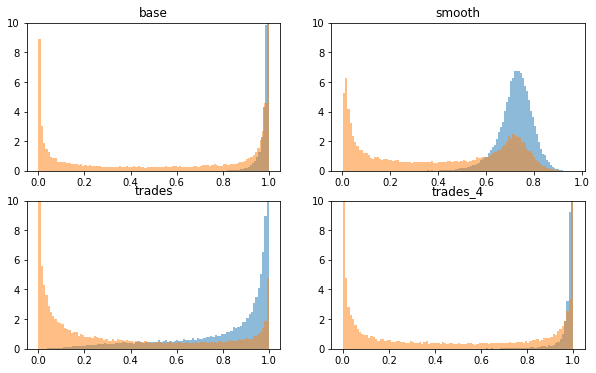

In [98]:
plt.figure(figsize=(10,6))
for i, c in enumerate(confs_io):
#     plt.figure()
    plt.subplot(2, 2, i+1)
    plt.title(aug_types[i])
    plt.hist(c[0], 100, density=True, alpha=0.5)
    plt.hist(c[1], 100, density=True, alpha=0.5)
    plt.ylim([0, 10])
    
    
# plt.figure(figsize=(10,6))
# for i, c in enumerate(memfeatures_io):
# #     plt.figure()
#     plt.subplot(2,2,i+1)
#     plt.title(aug_types[i])
#     plt.hist(c[0], 100, density=True, alpha=0.5)
#     plt.hist(c[1], 100, density=True, alpha=0.5) 
#     plt.ylim([0, 5])

## mem v.s. Recall

In [659]:
aug_type = 'base'
dataset = 'cifar100'
trial = 0

base, baseeval, confs_dict = compute_feature(aug_type, trial, dataset)

# scatter all training samples
# scores = base
# scores = 1 / (1 + np.exp(-base))
# scores = baseeval
# scores = 1 / (1 + np.exp(-baseeval))

computing mean & var for in & out
test one model


MIA AUROC is 0.7618, success rate is 0.7562 with threshold 3.5119


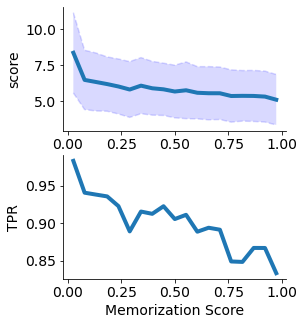

MIA AUROC is 0.9072, success rate is 0.8031 with threshold -0.0988


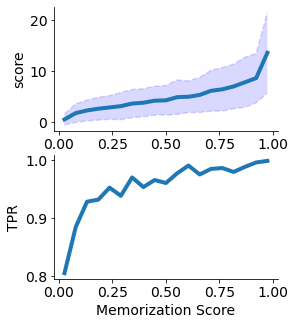

In [673]:
# s_tt = [1 / (1 + np.exp(-base)), 1 / (1 + np.exp(-baseeval))]
s_tt = [base, baseeval]

suffixes = ['conf', 'mem']

for i_tt, scores in enumerate(s_tt):
    FPR = np.linspace(0, 1, 101)
    indicator = np.zeros(sample_num, dtype=np.bool_)
    indicator[samplelist[trial]] = True
    scores_io = [scores[indicator], scores[np.logical_not(indicator)]]
    metrics = computeMetrics(scores_io, FPR)
    print('MIA AUROC is %.4f, success rate is %.4f with threshold %.4f' % (metrics['AUROC'], metrics['acc_opt'], metrics['thr_opt'], ))

    sids = np.array(samplelist[trial])
    sids = sids[sids < 50000]

    mem = tr_mem[sids]
    scores = scores[sids]

    inds = np.argsort(mem)
    mem = mem[inds]
    scores = scores[inds]

#     plt.figure(figsize=(17, 5))
#     plt.subplot(1,2,1)
#     plt.scatter(mem, scores, s=1)

    # mean in bins
    bin_num = 20
    bins = np.linspace(0, 1, bin_num)
#     bins = bins[np.newaxis, :]
#     mem_pb = mem[:, np.newaxis]
#     inds = mem_pb <= bins
#     nums = inds.sum(0)
#     sums = ((scores[:, np.newaxis] > metrics['thr_opt']) * inds).sum(0)
#     nums = nums[1:] - nums[:-1]
#     sums = sums[1:] - sums[:-1]
#     mean = sums / nums
#     mean_scores = sums_scores / nums

    scores_pb = []
    bins_f = bins.copy()
    bins_f[-1] = 1.01
    for i in range(bin_num - 1):
        scores_pb.append(scores[np.logical_and(mem>=bins_f[i], mem<bins_f[i+1])])
        
    x = (bins[:-1] + bins[1:]) / 2
    means = np.array([m.mean() for m in scores_pb])
    stds = np.array([m.std() for m in scores_pb])
    recall = np.array([(m>metrics['thr_opt']).mean() for m in scores_pb])
    y1 = means - stds
    y2 = means + stds
    
    plt.figure(figsize=(4, 5))
    plt.subplot(2, 1, 1)
    plt.plot(x, y1, '--', c='b', alpha=0.15)
    plt.plot(x, y2, '--', c='b', alpha=0.15)
    plt.fill_between(x, y1, y2, facecolor="b", alpha=0.15)
    plt.plot(x, means, linewidth=4)
#     plt.xlabel('Memorization')
    plt.ylabel('score')
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
#     plt.figure(figsize=(4, 2.4))
    plt.subplot(2, 1, 2)
    plt.plot(x, recall, linewidth=4)
    plt.xlabel('Memorization Score')
    plt.ylabel('TPR')
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # plt.title('Confidence Feature')
    # plt.title('Memorization Feature')
    plt.savefig('score_recall_%s.pdf' % suffixes[i_tt], dpi=300, bbox_inches='tight')
    plt.show()

## scatter of generalization v.s. privacy

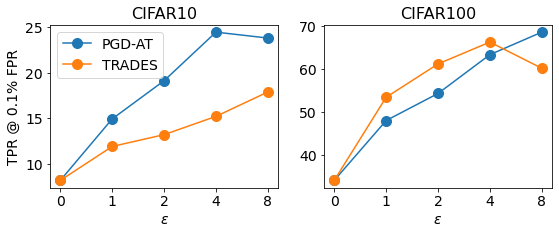

In [266]:
eps = [0, 1, 2, 3, 4]

names = ['PGD-AT', 'TRADES']
tprs_pgdat_cifar10 = [8.195178894507372, 14.926307527016373, 19.10719610934087, 24.426624333361886, 23.779405248727866]
tprs_trades_cifar10 = [8.195178894507372, 11.908775282518596, 13.2017384441113, 15.203423098225022, 17.875220061267544]

tprs_pgdat_cifar100 = [34.17497639836016, 48.07874248544216, 54.37140333675232, 63.39159722256768, 68.62745450472025]
tprs_trades_cifar100 = [34.17497639836016, 53.48717768893606, 61.23502888856401, 66.31698670036681, 60.23089259201784]


plt.figure(figsize=(9, 3))
plt.subplot(1, 2, 1)
plt.plot(eps, tprs_pgdat_cifar10, '.-', ms=20)
plt.plot(eps, tprs_trades_cifar10, '.-', ms=20)
plt.legend(names)
plt.xticks(eps, [0, 1, 2, 4, 8])
plt.xlabel('$\epsilon$')
plt.ylabel('TPR @ 0.1% FPR')
plt.title('CIFAR10', fontsize=16)

plt.subplot(1, 2, 2)
plt.plot(eps, tprs_pgdat_cifar100, '.-', ms=20)
plt.plot(eps, tprs_trades_cifar100, '.-', ms=20)
# plt.legend(names)
plt.xlabel('$\epsilon$')
plt.xticks(eps, [0, 1, 2, 4, 8])
plt.title('CIFAR100', fontsize=16)
plt.savefig('eps_tpr_plot.pdf', dpi=300, bbox_inches='tight')

plt.show()

In [258]:
ids = 1
print(aug_types[ids])
print(np.mean(infos_multi[aug_types[ids]][0]))
# ids = 12
# print(aug_types[ids])
# print(np.mean(infos_multi[aug_types[ids]][0]))

base
34.17497639836016


In [19]:
infos_multi['none']

([58.81922257720979,
  54.63817872737575,
  31.372680153820433,
  37.78145695364238,
  33.461064276431976,
  37.9261032957531,
  62.56633059166887,
  33.3698284728443,
  58.36187689135712,
  30.044978517722882],
 [25.60902555910543,
  29.1690276990767,
  6.146129409797693,
  17.983443708609272,
  4.248442237846123,
  7.861917589544048,
  34.41562748739719,
  13.267642082213596,
  37.704100295966214,
  5.618958109559613],
 [0.9577432429457089,
  0.9543257682291855,
  0.9083931084753142,
  0.9322253509450686,
  0.906478732270656,
  0.9239728453664848,
  0.9645422684090296,
  0.9214895166526668,
  0.9644281436985787,
  0.9030680220435737],
 [0.9410499999999999,
  0.93185,
  0.8911,
  0.88765,
  0.8897333333333334,
  0.9118333333333333,
  0.9418166666666666,
  0.8851666666666667,
  0.9394333333333333,
  0.8901333333333333],
 [0.7444833333333334,
  0.7340666666666666,
  0.6729333333333334,
  0.6732,
  0.6750833333333333,
  0.7103999999999999,
  0.7609166666666667,
  0.67145,
  0.75205,
  0.

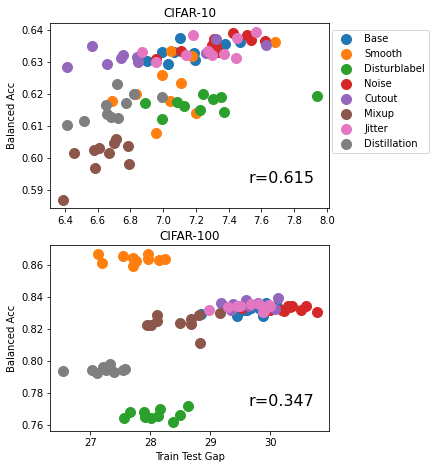

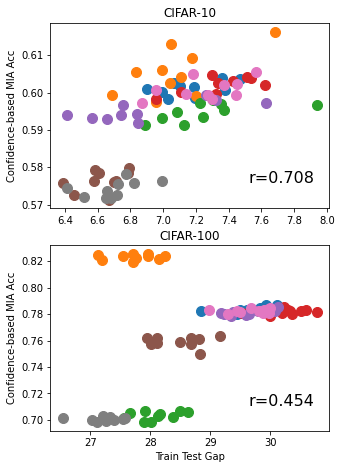

In [21]:
#### mpl.rcParams["font.size"] = 14


# 13 + 7 + 2
aug_types = ["none", "base", "smooth", "disturblabel", "noise", "cutout", "mixup", "jitter", "pgdat", "trades", "distillation", "pgdat_4", "trades_4"]
aug_types += ["smooth_none", "disturblabel_none", "noise_none", "cutout_none", "mixup_none", "jitter_none", 'distillation_none']
aug_types += ['AWP', 'TradesAWP']

def printed(name):
    if name == 'cifar10':
        return 'CIFAR-10'
    elif name =='cifar100':
        return 'CIFAR-100'
    else:
        raise ValueError
        return None

# ids_list = [0, 4]
ids_list = [3, 4]
# plt_inds = range(len(aug_types))
# plt_inds = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
plt_inds = [1, 2, 3, 4, 5, 6, 7, 10]
names = [aug_types[i].capitalize() for i in plt_inds]

# plt_inds = [8, 9, 11, 12]
# names = [r'PGD-AT($\epsilon=8$)', r'TRADES($\epsilon=8$)', r'PGD-AT($\epsilon=4$)', r'TRADES($\epsilon=4$)']
# plt_inds = [8, 9, 20, 21]
# names = ['PGD-AT', 'TRADES', 'AWP', 'TradesAWP']

for i_all in range(2):
    plt.figure(figsize=(5, 7.5))
    for i_tt, data_name in enumerate(['cifar10', 'cifar100']):
#     for i_tt, data_name in enumerate(['cifar10', ]):
        with open("others_project/lixiao/privacy_and_aug/data_new/%s_acc_all.txt" % data_name, "r") as f:
            accs = eval(f.read())
        
        with open("others_project/lixiao/privacy_and_aug/data_new/%s_awp_acc.txt" % data_name, "r") as f:
            accs.update(eval(f.read()))
            
        with open("others_project/lixiao/privacy_and_aug/data_new/%s_info.txt" % data_name, "r") as f:
            infos = eval(f.read())

        with open("others_project/lixiao/privacy_and_aug/data_new/%s_multi_info.txt" % data_name, "r") as f:
            infos_multi = eval(f.read())
            
        with open("others_project/lixiao/privacy_and_aug/data_new/%s_awp_multi_info.txt" % data_name, "r") as f:
            infos_multi.update(eval(f.read()))

        xs = [np.array(accs[aug_types[i]][0]) - np.array(accs[aug_types[i]][1]) for i in plt_inds]
        ys = [np.array(infos_multi[aug_types[i]][ids_list[i_all]]) for i in plt_inds]

        plt.subplot(2, 1, i_tt+1)
        for x, y in zip(xs, ys):
            plt.scatter(x, y, s=100, alpha=1)

    #     xs = np.array(xs).mean(1)
    #     ys = np.array(ys).mean(1)

        xs = np.array(xs).flatten()
        ys = np.array(ys).flatten()

        rs = np.corrcoef(xs, ys)[0, 1]
#         m, c = np.linalg.lstsq(np.pad(xs[:, np.newaxis], ((0, 0), (0, 1)), constant_values=1), ys)[0]
#     #     m = ys.std() / xs.std()
#     #     c = ys.mean() - xs.mean() / xs.std() * ys.std()
#         offx, offy = 0.1, 0.1
#         x_line = np.linspace(offx*xs.max()+(1-offx)* xs.min(), (1-offx)*xs.max()+offx* xs.min(), 100)
#         plt.plot(x_line, m*x_line+c, '--', linewidth=5, color='black', alpha=0.7)

        offx, offy = 0.27, 0.9
#         r_square = np.corrcoef(m * xs + c, ys)[0, 1] ** 2
        plt.text((1-offx)*xs.max()+offx* xs.min(), (1-offy)*ys.max()+offy*ys.min(), 'r=%.3f' % rs, fontsize=16)
#         plt.text((1-offx)*xs.max()+offx* xs.min(), (1-offy)*ys.max()+offy*ys.min(), r'$R^2$=%.3f' % r_square, fontsize=16)
#         print('r is %f' % rs**2)
#         print('r2 is %f' % r_square)

        if i_tt == 0 and i_all == 0:
            plt.legend(names, loc=(1.01, 0.3)) #
#             plt.legend(names, loc=(1.01, 0.47)) #

        if i_tt == 1:
            plt.xlabel('Train Test Gap')

        plt.title(printed(data_name))
        if i_all == 0:
#             plt.ylabel('TPR @ 0.1% FPR')
            plt.ylabel('Balanced Acc')
        else:
            plt.ylabel('Confidence-based MIA Acc')
    #     plt.tight_layout()
#     if i_all==0:
#         plt.savefig('TPR_gap.pdf', dpi=300, bbox_inches='tight')
#     else:
#         plt.savefig('trad_acc_gap.pdf', dpi=300, bbox_inches='tight')
        
    if i_all==0:
        plt.savefig('TPR_gap_at.pdf', dpi=300, bbox_inches='tight')
    else:
        plt.savefig('trad_acc_gap_at.pdf', dpi=300, bbox_inches='tight')


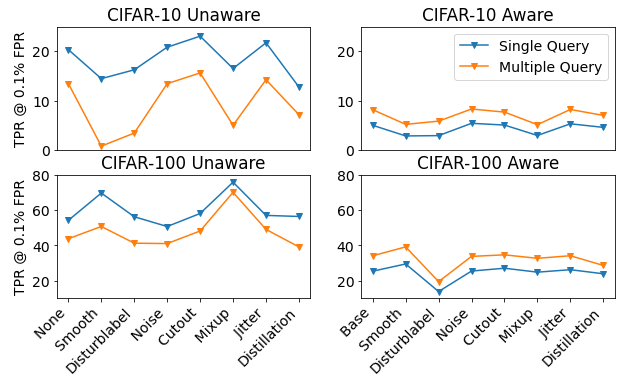

In [705]:
plt.figure(figsize=(10, 5))
for i_tt, data_name in enumerate(['cifar10', 'cifar100']):
    aug_types = ["none", "base", "smooth", "disturblabel", "noise", "cutout", "mixup", "jitter", "pgdat", "trades", "distillation", "pgdat_4", "trades_4"]
    aug_types += ["smooth_none", "disturblabel_none", "noise_none", "cutout_none", "mixup_none", "jitter_none", 'distillation_none']
    with open("others_project/lixiao/privacy_and_aug/paperdata/%s_acc_all.txt" % data_name, "r") as f:
        accs = eval(f.read())

    with open("others_project/lixiao/privacy_and_aug/paperdata/%s_info.txt" % data_name, "r") as f:
        infos = eval(f.read())

    with open("others_project/lixiao/privacy_and_aug/paperdata/%s_multi_info.txt" % data_name, "r") as f:
        infos_multi = eval(f.read())

    # plt_inds = range(len(aug_types))
#     plt_inds = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
    left_inds = [0, 13, 14, 15, 16, 17, 18, 19]
    right_inds = [1, 2, 3, 4, 5, 6, 7, 10]
#     plt_inds = left_inds + right_inds
    suffixes = ['Unaware', 'Aware']
    for pi, plt_inds in enumerate([left_inds, right_inds]):
        xs = [aug_types[i].split('_')[0].capitalize() for i in plt_inds]
        ys = [infos[aug_types[i]][0] for i in plt_inds]
        ys2 = [infos_multi[aug_types[i]][0] for i in plt_inds]
        
        xs = ['%12s' % x for x in xs]
        
        plt.subplot(2, 2, i_tt*2 + pi + 1)
        plt.plot(xs, ys, 'v-')
        plt.plot(xs, ys2, 'v-')
    #     plt.legend([aug_types[i] for i in plt_inds], loc=(1.02, -0.05))
        plt.title('%s %s' % (printed(data_name), suffixes[pi]))
    #     plt.xlabel('Train Test Gap')
        plt.xticks(rotation=45, ha="right")

        if i_tt == 0:
            if pi == 1:
                plt.legend(['Single Query', 'Multiple Query'])
            ax = plt.gca()
            ax.axes.xaxis.set_visible(False)
        if pi == 0:
            plt.ylabel('TPR @ 0.1% FPR')
        if i_tt == 0:
            plt.ylim([0, 25])
        else:
            plt.ylim([10, 80])
            
plt.savefig('sing_multi.pdf', dpi=300, bbox_inches='tight')


1

# End